# lab 09-2 : XOR prob

In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
#tf.enable_eager_execution() - default in tf  2.0
tf.random.set_seed(0)

## 예시 데이터 
x: 2차원 array
-> x1,x2 기준으로 y를 0 or 1로 구분


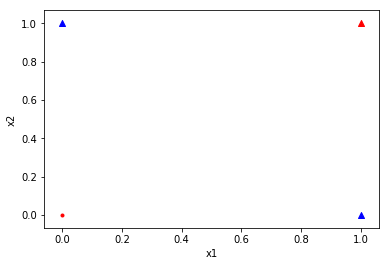

In [65]:
x_data = [[0, 0],
[0, 1],
[1, 0],
[1, 1]]
y_data = [[0],
[1],
[1],
[0]]

plt.scatter(x_data[0][0],x_data[0][1],c='red',marker='.')

plt.scatter(x_data[3][0],x_data[3][1], c='red' , marker='^')
plt.scatter(x_data[1][0],x_data[1][1], c='blue' , marker='^')
plt.scatter(x_data[2][0],x_data[2][1], c='blue' , marker='^')
##if 함수 써서 표현?

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [66]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(50000).batch(len(x_data))

def preprocess_data(features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels

In [17]:
##weight&bias 생성 
#random_normal 2.0에서 사용불가
W1 = tf.Variable(tf.random.normal([2, 1]), name='weight1')
b1 = tf.Variable(tf.random.normal([1]), name='bias1')

W2 = tf.Variable(tf.random.normal([2, 1]), name='weight2')
b2 = tf.Variable(tf.random.normal([1]), name='bias2')

W3 = tf.Variable(tf.random.normal([2, 1]), name='weight3')
b3 = tf.Variable(tf.random.normal([1]), name='bias3')

In [18]:
#layer 생성
def neural_net(features):
    layer1 = tf.sigmoid(tf.matmul(features, W1) + b1)  ## .nn 없이 사용가능 ##softmax는 사용불가 nn. or math.필요
    layer2 = tf.sigmoid(tf.matmul(features, W2) + b2)
    layer3 = tf.concat([layer1, layer2],-1) ## axis=-1
    layer3 = tf.reshape(layer3, shape = [-1,2])
    hypothesis = tf.sigmoid(tf.matmul(layer3, W3) + b3)
    return hypothesis
#loss func(in logistic reg) 
#.math.log로 수정할 것
def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(hypothesis) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)


def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32) ##boolean 값을 float32값으로 cast
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32)) #실제 y값과 예측값의 비교
    return accuracy

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features),labels)
    return tape.gradient(loss_value, [W1, W2, W3, b1, b2, b3])
#keras - loss func & accuracy 이용
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [19]:
EPOCHS = 50000

for step in range(EPOCHS):
    for features, labels  in dataset:
        features, labels = preprocess_data(features, labels)
        grads = grad(neural_net(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W1, W2, W3, b1, b2, b3]))
        if step % 5000 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(neural_net(features),labels)))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(neural_net(x_data),y_data)
print("Testset Accuracy: {:.4f}".format(test_acc))
##시간 단축 방법???

Iter: 0, Loss: 0.7016
Iter: 5000, Loss: 0.6894
Iter: 10000, Loss: 0.6732
Iter: 15000, Loss: 0.6322
Iter: 20000, Loss: 0.5765
Iter: 25000, Loss: 0.5298
Iter: 30000, Loss: 0.4297
Iter: 35000, Loss: 0.2767
Iter: 40000, Loss: 0.1617
Iter: 45000, Loss: 0.1036
Testset Accuracy: 1.0000


# lab 09 -4 tensorboard 

## Solve XOR prob with 4-layer NN 

* layer 1 : 2,10

In [67]:
W1 = tf.Variable(tf.random.normal([2, 10]), name='weight1')
b1 = tf.Variable(tf.random.normal([10]), name='bias1')

W2 = tf.Variable(tf.random.normal([10, 10]), name='weight2')
b2 = tf.Variable(tf.random.normal([10]), name='bias2')

W3 = tf.Variable(tf.random.normal([10, 10]), name='weight3')
b3 = tf.Variable(tf.random.normal([10]), name='bias3')

W4 = tf.Variable(tf.random.normal([10, 1]), name='weight4')
b4 = tf.Variable(tf.random.normal([1]), name='bias4')

In [76]:
#eager default 이므로 contrib 모두 제거
def neural_net(features):
    layer1 = tf.sigmoid(tf.matmul(features, W1) + b1)
    layer2 = tf.sigmoid(tf.matmul(layer1, W2) + b2)
    layer3 = tf.sigmoid(tf.matmul(layer2, W3) + b3)
    hypothesis = tf.sigmoid(tf.matmul(layer3, W4) + b4)

    with tf.summary.record_summaries_every_n_global_steps(1):
        tf.summary.histogram("weights1", W1)
        tf.summary.histogram("biases1", b1)
        tf.summary.histogram("layer1", layer1)

        tf.summary.histogram("weights2", W2)
        tf.summary.histogram("biases2", b2)
        tf.summary.histogram("layer2", layer2)

        tf.summary.histogram("weights3", W3)
        tf.summary.histogram("biases3", b3)
        tf.summary.histogram("layer3", layer3)

        tf.summary.histogram("weights4", W4)
        tf.summary.histogram("biases4", b4)
        tf.summary.histogram("hypothesis", hypothesis)
    return hypothesis

def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels * tf.log(hypothesis) + (1 - labels) * tf.log(1 - hypothesis))
    with tf.summary.record_summaries_every_n_global_steps(1):
        tf.summary.scalar('loss', cost)
    return cost

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features),labels)
    return tape.gradient(loss_value, [W1, W2, W3, W4, b1, b2, b3, b4])

In [75]:
EPOCHS = 50000
log_path = '/tmp/summaries/train'
writer = tf.summary.create_file_writer(log_path)
##수정:writer = tf.contrib.summary.create_file_writer(log_path)에서 위와 같이 변경
global_step=tf.compat.v1.train.get_or_create_global_step()     
##수정:global_step=tf.train.get_or_create_global_step()  
# global step variable
writer.set_as_default()

for step in range(EPOCHS):
    global_step.assign_add(1)
    for features, labels  in dataset:
        features, labels = preprocess_data(features, labels)
        grads = grad(neural_net(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W1, W2, W3, W4, b1, b2, b3, b4]))
        if step % 50 == 0:
            loss_value = loss_fn(neural_net(features),labels)
            print("Iter: {}, Loss: {:.4f}".format(step, loss_value))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(neural_net(x_data),y_data)
print("Testset Accuracy: {:.4f}".format(test_acc))

RuntimeError: __iter__() is only supported inside of tf.function or when eager execution is enabled.